In [3]:
%pip install bigtree

   ---------------------------------------- 0.0/76.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/76.9 kB ? eta -:--:--
   ----- ---------------------------------- 10.2/76.9 kB ? eta -:--:--
   --------------------- ------------------ 41.0/76.9 kB 326.8 kB/s eta 0:00:01
   ---------------------------------------- 76.9/76.9 kB 605.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [15]:
import numpy as np
import qiskit.transpiler

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library.standard_gates import RYGate, IGate
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit.primitives import Sampler


from bigtree import BinaryNode, preorder_iter


def test_bool(tupel):
    return (tupel[0] and tupel[1]) or (tupel[0] and tupel[2]) or  (tupel[1] and tupel[2])
    
def test_one(tupel):
    return 1

def test_or(tupel):
    return (tupel[0] or tupel[1])

def test_and(tupel):
    return (tupel[0] and tupel[1])

def test_range(a,b):
    # a..start, b..end, n .. size of tupel
    
    def f(tupel):
        x = ''.join([str(digit) for digit in tupel])[::-1]
        if a <= int(x,2) and int(x,2) < b:
            return 1
        else: 
            return 0
    return f

# ------------------        

def valid_cards(card_tupel, players = 2,cards_in_hand=2, points = 'none'):
    # cards ordered descending (highest card first), no trump cards
    # h ... number of cards in hand

    ### states:
    # 00i hand player i
    # 01i played by player i
    # 11i stack of player
    # 100 not distributed
  
    
    c = 4 #total number of cards
    s = 3 #number of playerstate-bits
    n =  c*s #length of tupel

    if points == 'none':
        points = np.ones(n)
    
    
    eval_op = 0
    cards = []
    # extract tupels corresponding to individual cards
    for i in range(c):
        cards += [''.join([str(bit) for bit in card_tupel[3*i:3*(i+1)]])]
    print(cards)
        
    #number of cards in hand
    check = [0,0,0] # not in play, player 1 , player 2
    for card in cards:
        if card == '000':
            check[1] += 1
        elif card == '001':
            check[2] += 1
        elif card == '100':       
            check[0] += 1
    print('# cards player 1, # cards player 2, # cards not in play:', check)

    condition = (check[1] == cards_in_hand) and (check[2] == cards_in_hand)

     #nur ein beispiel

    cards_player0 = [i for i, card in enumerate(cards) if card == '110']
    cards_player1 = [i for i, card in enumerate(cards) if card == '111']

    for i in range(len(cards_player0)):
        start_vec = np.zeros(n-3) # platz für eine karte
        proj_vec = np.insert(start_vec,3*i,[1,1,0])
        state = Statevector(proj_vec)
        #print(state)
        eval_op = points[i]*state.to_operator()
    print(eval_op)

    
    if condition:
        print('valid')
        return 1
    else:
        print('invalid')
        return 0

valid_cards('000001000001')  
# ----------------------
    
def get_projectionprobs(f, n, projection_bit):
    #f .... boolean function on n bits
    p_proj = 0
    p_full = 0
    for i in range(2**n):
        argument = []
        for k in range(n):
            argument+= [i//2**(n-1-k)] 
            i = i % 2**(n-1-k)
        if argument[projection_bit] == 0:
            p_proj += f(argument)
        p_full += f(argument)

    
    #Define restricted functions
    def f_one(tupel):
        t = tupel.copy()
        t.insert(projection_bit,1)
        return f(t)
    
    def f_zero(tupel):
        t = tupel.copy()
        t.insert(projection_bit,0)
        return f(t)
    
    if p_full > 0:
        p = round(p_proj/p_full,2)
    else:
        p = -1
    
    return p, f_zero, f_one 


def get_fulltree(f,n,prefix=""):
    
    p, f_left, f_right = get_projectionprobs(f, n, 0)
    if p>= 0:
        root = BinaryNode(prefix, p = p)
       # print(prefix,"\t n=",n,"p=",p)
    
    else:
        return
    
    if n > 1:
        root.children = [get_fulltree(f_left,n-1,prefix+"0"),get_fulltree(f_right,n-1,prefix+"1")]
    #if n == 1:
    #    print(f([0]), f([1]))   
    return root

    
def make_qsp(f,n,circuit):
    gates = get_fulltree(f,n) 
    gates.show(attr_list=['p'])
        
    for node in preorder_iter(gates):
        
        cond = node.node_name[::-1] # string, aber noch in umgkehrter reihenfolge
        p = node.get_attr("p")
        work_qubit = node.depth-1
        cond_qubits = range(0,work_qubit)
        
        # print(work_qubit, cond_qubits, cond,p)
        
        theta = 2*np.arccos(np.sqrt(p))
        if node.is_root:
            p_gate = RYGate(theta)
        else:
            p_gate = RYGate(theta).control(len(cond), ctrl_state=cond )
        
        circuit.append(p_gate, range(node.depth))

    
    

#N= 5
#qr = QuantumRegister(N)
#qc = QuantumCircuit(qr)    
#make_qsp(test_range(3,11),4,qc)
#make_qsp(test_bool,3,qc)


#qc.measure_all()
#qiskit.compiler.transpile(qc, optimization_level=2)
#qc.draw()

#results = Sampler().run(qc).result()
#statistics = results.quasi_dists[0].binary_probabilities()
#display(plot_histogram(statistics))

['000', '001', '000', '001']
# cards player 1, # cards player 2, # cards not in play: [0, 2, 2]
0
valid


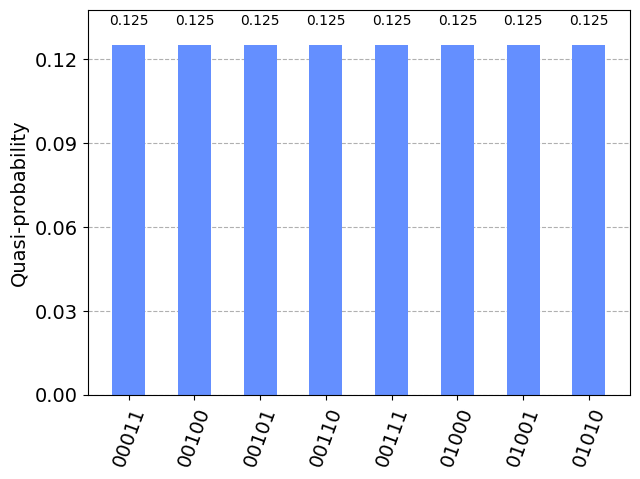

In [8]:
results = Sampler().run(qc).result()
statistics = results.quasi_dists[0].binary_probabilities()
display(plot_histogram(statistics))

In [9]:
#a= valid_cards2([0,0,0,1,0,0,0,1,0,0,0,1])
#b= valid_cards2([0,1,0,0,0,0,0,0,0,0,1,1])
c= valid_cards2([1,1,0,0,0,0,1,1,1,1,1,0])



['110', '000', '111', '110']
# cards player 1, # cards player 2, # cards not in play: [1, 0, 0]
Operator([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
           0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0

In [121]:
a= ['000', '100', '010', '001']

In [9]:
np.diagflat([])

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [12]:
a= [4,5,6]
a.index(6)

2

In [14]:
a= np.zeros(4)

In [37]:
b=np.insert(a,1,[1,2,4])
psi = Statevector(b)

In [38]:
print(psi.to_dict())

{'01': (1+0j), '10': (2+0j), '11': (4+0j)}


In [39]:
p = psi.to_operator()

In [40]:
p

Operator([[ 0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
          [ 0.+0.j,  1.+0.j,  2.+0.j,  4.+0.j],
          [ 0.+0.j,  2.+0.j,  4.+0.j,  8.+0.j],
          [ 0.+0.j,  4.+0.j,  8.+0.j, 16.+0.j]],
         input_dims=(2, 2), output_dims=(2, 2))
